# Loading Data

In [2]:
#Connect to google drive data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import nltk
import re

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Hackathon M2/Our Data/Customer Reviews - SKYTRAX.csv')

In [ ]:
df.head(5)

,score,title,user_country,user_name,review_date,is_verified,review_body,airline
0,7.0,"""my trip was pretty good.""",United States,N Palustre,9th February 2022,0,My flight from Dulles to Paris was great. My f...,Air France
1,1.0,"""my baggage didn't make it""",Lebanon,Nour El Khoury,27th January 2022,1,"I went for 2 months to Nice, when I arrived i...",Air France
2,3.0,Air France customer review,United States,Daniel Rabourn,26th January 2022,1,"Yesterday Jan 25, we flew Colombo, Sri Lanka t...",Air France
3,8.0,"""great alternative to fly across the Atlantic""",United Kingdom,D Garlin,19th January 2022,1,First medium-haul experience with Air France....,Air France
4,8.0,"""A pleasurable experience!""",United States,S Gillemo,4th January 2022,1,BOD-CDG-ATL: Was having some major issue with...,Air France


In [ ]:
# check the distribution
df['score'].value_counts()

1.0     2172
10.0    1390
9.0     1032
8.0      809
2.0      710
3.0      529
7.0      526
5.0      447
4.0      389
6.0      358
Name: score, dtype: int64

# Pre-Processing

## Full Reviews

In [ ]:
# add title to review_body
df['full_review'] = df['title'] + df['review_body']

In [ ]:
# new df with only relevant inputs for TF IDF + Classifier (might experiment with other variables later)
df_slim = df[['score', 'full_review']]

In [ ]:
df_slim.head(5)

,score,full_review
0,7.0,"""my trip was pretty good.""My flight from Dulle..."
1,1.0,"""my baggage didn't make it"" I went for 2 month..."
2,3.0,"Air France customer reviewYesterday Jan 25, we..."
3,8.0,"""great alternative to fly across the Atlantic""..."
4,8.0,"""A pleasurable experience!"" BOD-CDG-ATL: Was h..."


## Labeling by score

In [ ]:
# even reviews with score of 5 seem bad
df_slim[df_slim['score'] == 5]

,score,full_review
14,5.0,"""All in all, a decent experience"" It was very ..."
58,5.0,"""had the mask only on the chin"" Today as I boa..."
87,5.0,"""My disappointment is with the food service"" F..."
127,5.0,"""Overall impression: sloppy product"" Flight fr..."
160,5.0,"""most uncomfortable flight"" Mauritius to Paris..."
...,...,...
8296,5.0,"""will not be flying with Ryanair again"" Liverp..."
8298,5.0,"""not be using Ryanair transfer services"" Venic..."
8312,5.0,"""avoid this airline from now on"" Rome to Budap..."
8382,5.0,"""use again purely for price"" Flew from Stanste..."


In [ ]:
# reviews with 6 are pretty generic, from seven is when they start being fairly positive
df_slim[df_slim['score'] == 6]

,score,full_review
16,6.0,"""Check-in was a mess"" Check-in was a mess. The..."
92,6.0,"""checked size and weight of cabin bags"" Paris ..."
124,6.0,"""My issue is with the baggage policy"" First, t..."
133,6.0,"""Very poor business class"" Bought a seat in bu..."
176,6.0,"""cabin looked very tired and in need of a refr..."
...,...,...
8324,6.0,"""should improve some parts"" Wroclaw to Warsaw...."
8348,6.0,"""I would fly with Ryanair again"" Rome to Stans..."
8369,6.0,"""attitude of that wonderful lady"" Stansted to ..."
8388,6.0,"""you cannot have high expectations"" Ryanair pr..."


In [ ]:
# create binary label of reviews from scores giving on review
'''
If score is 7-10 is a good rating
6 is neutral
1-5 is bad

If score is 7-10 then 1 (labeled good)
if score is 6 these rows will be ignored
if 1-5 then 0 (labeled bad)
'''

# filter our reviews with 6
df_slimmer = df_slim[df_slim['score'] != 6]

# label reviews
labels = []
for row in df_slimmer['score']:
    if row <= 5:    labels.append(0) # bad reviews
    else:   labels.append(1) # good reviews

df_slimmer['label'] = labels


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Lemmatization

In [ ]:
# lower case
df_slimmer['lower_case'] = df_slimmer['full_review'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))
# remove possible HTML tags and any URLS
from bs4 import BeautifulSoup
df_slimmer['pre_process']=df_slimmer['lower_case'].apply(lambda x: BeautifulSoup(x).get_text())
import re
df_slimmer['pre_process']=df_slimmer['pre_process'].apply(lambda x: re.sub(r"http\S+", '', x))
# contractions
def contractions(s):
 s = re.sub(r"won’t", "will not",s)
 s = re.sub(r"-", " to ",s) # for things like CDG-ATL
 s = re.sub(r"would’t", "would not",s)
 s = re.sub(r"could’t", "could not",s)
 s = re.sub(r"cannot", "can not",s)
 s = re.sub(r"\’d", " would",s)
 s = re.sub(r"can\’t", "can not",s)
 s = re.sub(r"n\’t", " not", s)
 s= re.sub(r"\’re", " are", s)
 s = re.sub(r"\’s", " is", s)
 s = re.sub(r"\’ll", " will", s)
 s = re.sub(r"\’t", " not", s)
 s = re.sub(r"\’ve", " have", s)
 s = re.sub(r"\’m", " am", s)
 return s

# replace contractions
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x:contractions(x))
# remove non-alphabet characters
nltk.download('punkt')
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: " ".join([re.sub("[^A-Za-z]+","", x) for x in nltk.word_tokenize(x)]))
df_slimmer = df_slimmer[['score', 'label', 'full_review', 'pre_process']]
# remove extra spaces
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: re.sub(' +', " ", x))
# remove stop words
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words("english")
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
# lemmatization
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
# pass over ready df
df_pp = df_slimmer[['score', 'label', 'pre_process']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# TD IDF + Classifiers Feature Extraction

## TD IDF Vector/Matrix

In [ ]:
# renaming columns to not get it twisted 
df_pp = df_pp.rename(columns={'pre_process': 'lemmatized'})

In [ ]:
# TD IDF using scikitlearn
from sklearn.model_selection import train_test_split

# split data
X_train,X_test,Y_train, Y_test = train_test_split(df_pp['lemmatized'], df_pp['label'], test_size=0.25, random_state=30)
print("Train: ",X_train.shape,Y_train.shape, "Test: ",(X_test.shape,Y_test.shape))

Train:  (6048,) (6048,) Test:  ((2017,), (2017,))


In [ ]:
# TD IDF vectorizer
print("TFIDF Vectorizer……")

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)
print(" done!")

TFIDF Vectorizer……
 done!


## SVM

In [ ]:
# SVM
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state=0)

In [ ]:
# fit training data into the model
svm.fit(tf_x_train,Y_train)

LinearSVC(random_state=0)

In [ ]:
# predict test data
y_test_pred = svm.predict(tf_x_test)


In [ ]:
# analyze results
from sklearn.metrics import classification_report

report = classification_report(Y_test, y_test_pred, output_dict=True)

In [ ]:
report

{'0': {'f1-score': 0.9298162976919454,
  'precision': 0.9293785310734464,
  'recall': 0.9302544769085768,
  'support': 1061},
 '1': {'f1-score': 0.9220303506017792,
  'precision': 0.9225130890052357,
  'recall': 0.9215481171548117,
  'support': 956},
 'accuracy': 0.9261279127416956,
 'macro avg': {'f1-score': 0.9259233241468623,
  'precision': 0.925945810039341,
  'recall': 0.9259012970316942,
  'support': 2017},
 'weighted avg': {'f1-score': 0.9261259826606122,
  'precision': 0.9261245089528666,
  'recall': 0.9261279127416956,
  'support': 2017}}

## Logistic Regression

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
logisticr = LogisticRegression(max_iter=1000,solver="saga")

In [ ]:
# fit model to trainning data
logisticr.fit(tf_x_train,Y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [ ]:
# predicting the test data
y_test_pred = logisticr.predict(tf_x_test)

In [ ]:
# analyze results
from sklearn.metrics import classification_report
report = classification_report(Y_test, y_test_pred, output_dict=True)

In [ ]:
report

{'0': {'f1-score': 0.9238721804511278,
  'precision': 0.9212746016869728,
  'recall': 0.9264844486333648,
  'support': 1061},
 '1': {'f1-score': 0.9150052465897167,
  'precision': 0.9178947368421052,
  'recall': 0.9121338912133892,
  'support': 956},
 'accuracy': 0.9196826970748636,
 'macro avg': {'f1-score': 0.9194387135204223,
  'precision': 0.9195846692645391,
  'recall': 0.919309169923377,
  'support': 2017},
 'weighted avg': {'f1-score': 0.9196695087746236,
  'precision': 0.9196726429404714,
  'recall': 0.9196826970748636,
  'support': 2017}}

In [ ]:
# save the model
filename = 'logisticsr_classifier.sav'
pickle.dump(logisticr, open(filename, 'wb'))

## Random Forests

In [ ]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=20, n_estimators=1000, random_state=0)

In [ ]:
# fit model to trainning data
clf.fit(tf_x_train,Y_train)

RandomForestClassifier(max_depth=20, n_estimators=1000, random_state=0)

In [ ]:
# predicting the test data
y_test_pred = clf.predict(tf_x_test)

In [ ]:
# analyze results
from sklearn.metrics import classification_report
report = classification_report(Y_test, y_test_pred, output_dict=True)

In [ ]:
report

{'0': {'f1-score': 0.886255924170616,
  'precision': 0.8913250714966635,
  'recall': 0.88124410933082,
  'support': 1061},
 '1': {'f1-score': 0.8752598752598754,
  'precision': 0.8698347107438017,
  'recall': 0.8807531380753139,
  'support': 956},
 'accuracy': 0.881011403073872,
 'macro avg': {'f1-score': 0.8807578997152457,
  'precision': 0.8805798911202326,
  'recall': 0.8809986237030669,
  'support': 2017},
 'weighted avg': {'f1-score': 0.8810441131846626,
  'precision': 0.881139258467543,
  'recall': 0.881011403073872,
  'support': 2017}}

### RF + GridSearch + CV

In [ ]:
# initialize gridsearch model

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 30, 40, 50, 100],
    'max_features': [3, 4, 5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 8, 10],
    'n_estimators': [100, 500, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 5, verbose = True)

In [ ]:
# Fit the grid search to the data
grid_search.fit(tf_x_train, Y_train)
grid_search.best_params_
# {'bootstrap': True,
#  'max_depth': 50,
#  'max_features': 5,
#  'min_samples_leaf': 3,
#  'min_samples_split': 4,
#  'n_estimators': 100}

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 100}

In [ ]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=0)

In [ ]:
# fit model to trainning data
clf.fit(tf_x_train,Y_train)

RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=0)

In [ ]:
# predicting the test data
y_test_pred = clf.predict(tf_x_test)

In [ ]:
# analyze results
from sklearn.metrics import classification_report
report = classification_report(Y_test, y_test_pred, output_dict=True)

In [ ]:
report

{'0': {'f1-score': 0.893657606103958,
  'precision': 0.9044401544401545,
  'recall': 0.883129123468426,
  'support': 1061},
 '1': {'f1-score': 0.8848735157459989,
  'precision': 0.873598369011213,
  'recall': 0.8964435146443515,
  'support': 956},
 'accuracy': 0.8894397620228062,
 'macro avg': {'f1-score': 0.8892655609249784,
  'precision': 0.8890192617256838,
  'recall': 0.8897863190563887,
  'support': 2017},
 'weighted avg': {'f1-score': 0.8894941998658772,
  'precision': 0.8898220350201901,
  'recall': 0.8894397620228062,
  'support': 2017}}

## XGBoost

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier


# parameter grid
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1], #so called `eta` value
              'max_depth': [5, 6, 7, 8],
              'min_child_weight': [8, 10, 11],
              'silent': [1],
              'subsample': [0.8, 0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [800, 900, 1000]
              }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=parameters, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(tf_x_train, Y_train), verbose=3, random_state=1001 )

# fit model with GS-CV
random_search.fit(tf_x_train, Y_train)
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fec178d6950>,
                   estimator=XGBClassifier(learning_rate=0.02, n_estimators=600,
                                           nthread=1, silent=True),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.7],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.05, 0.1],
                                        'max_depth': [5, 6, 7, 8],
                                        'min_child_weight': [8, 10, 11],
                                        'n_estimators': [800, 900, 1000],
                                        'nthread': [4],
                                        'objective': ['binary:logistic'],
                                        'silent': [1],
                                        'subsample': [0.8, 0.9]},
                   random_state=1001, scoring='roc_auc', 

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([141.12503552, 195.3893737 , 201.83231362, 202.55778003,
       142.68639787]), 'std_fit_time': array([0.43400143, 0.63233834, 1.12968749, 0.57291537, 2.47800802]), 'mean_score_time': array([0.61430184, 0.96983918, 0.87197741, 0.87802625, 0.28128171]), 'std_score_time': array([0.10817371, 0.07958129, 0.0695021 , 0.0592604 , 0.13069639]), 'param_subsample': masked_array(data=[0.8, 0.9, 0.9, 0.8, 0.9],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_silent': masked_array(data=[1, 1, 1, 1, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_objective': masked_array(data=['binary:logistic', 'binary:logistic',
                   'binary:logistic', 'binary:logistic',
                   'binary:logistic'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_nthread': ma

In [ ]:
# predicting the test data
y_test_pred = random_search.predict(tf_x_test)

In [ ]:
# analyze results
from sklearn.metrics import classification_report
report = classification_report(Y_test, y_test_pred, output_dict=True)

In [ ]:
report

{'0': {'f1-score': 0.899526066350711,
  'precision': 0.9046711153479504,
  'recall': 0.8944392082940622,
  'support': 1061},
 '1': {'f1-score': 0.8898128898128899,
  'precision': 0.8842975206611571,
  'recall': 0.895397489539749,
  'support': 956},
 'accuracy': 0.894893406048587,
 'macro avg': {'f1-score': 0.8946694780818004,
  'precision': 0.8944843180045537,
  'recall': 0.8949183489169056,
  'support': 2017},
 'weighted avg': {'f1-score': 0.8949222999797853,
  'precision': 0.8950146173208932,
  'recall': 0.894893406048587,
  'support': 2017}}

## Best Model

In [ ]:
import pickle
# the best model is:
best_model = svm
# save the model
filename = 'best_classifier.sav'
pickle.dump(best_model, open(filename, 'wb'))

# Predict for all other entries using best model

## Turn other comments into their TF IDF Forms

In [ ]:
df_full = pd.read_csv('/content/drive/MyDrive/Hackathon M2/Our Data/Merged_data_without_date.csv')

In [ ]:
df_full.tail(5)

,Unnamed: 0,score,title,user_country,user_name,is_verified,review_body,airline,seat,aircraft,layout,Unnamed: 0.1,Cabin Staff Service,Food & Beverages,Ground Service,Recommended,Route,Seat Comfort,Seat Type,Type Of Traveller,Value For Money,Inflight Entertainment,Wifi & Connectivity,link
34387,34387,NaN,NaN,NaN,SeatGuru,NaN,This is a terrible aircraft. Upon entering the...,Westjet_,20B,Westjet_Bombardier_Q400,NaN,16746.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...
34388,34388,NaN,NaN,NaN,SeatGuru,NaN,While these seats may be at the front of the p...,Westjet_,1B,Westjet_Bombardier_Q400,NaN,16747.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...
34389,34389,NaN,NaN,NaN,SeatGuru,NaN,Rather comfy despite it being listed at 17 inc...,Xiamen_Airlines_,None,Xiamen_Airlines_Boeing_787-8,NaN,16748.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Xiamen_Airl...
34390,34390,NaN,NaN,NaN,SeatGuru,NaN,I was very satisfied with my flight. The Fligh...,Xiamen_Airlines_,1A,Xiamen_Airlines_Boeing_787-9,NaN,16749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Xiamen_Airl...
34391,34391,NaN,NaN,NaN,SeatGuru,NaN,AMS-XIA in May 2018 (codeshare KLM-Xiamenair)....,Xiamen_Airlines_,14A,Xiamen_Airlines_Boeing_787-9,NaN,16750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Xiamen_Airl...


## Pre-Processing

### Full Reviews

In [ ]:
# add title to review_body
c_w_t = []
for i, row in enumerate(df_full['title']):
  if row != np.nan:
    c_w_t.append(str(row) + str(df_full['review_body'].iloc[i]))
  else:
    c_w_t.append(df_full['review_body'].iloc[i])

In [ ]:
df_full['full_review'] = c_w_t

In [ ]:
# new df with only relevant inputs for TF IDF + Classifier (might experiment with other variables later)
df_slim = df_full[['score', 'full_review']]

### Labeling by score

In [ ]:
# create binary label of reviews from scores giving on review
'''
If score is 7-10 is a good rating
6 is neutral
1-5 is bad

If score is 7-10 then 1 (labeled good)
if score is 6 these rows will be ignored
if 1-5 then 0 (labeled bad)
'''

# filter our reviews with 6
df_slimmer = df_slim[df_slim['score'] != 6]

# label reviews
labels = []
for row in df_slimmer['score']:
    if (row <= 5):    labels.append(0) # bad reviews
    else:   labels.append(1) # good reviews

df_slimmer['label'] = labels


### Lemmatization

In [ ]:
# lower case
df_slimmer['lower_case'] = df_slimmer['full_review'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))
# remove possible HTML tags and any URLS
from bs4 import BeautifulSoup
df_slimmer['pre_process']=df_slimmer['lower_case'].apply(lambda x: BeautifulSoup(x).get_text())
import re
df_slimmer['pre_process']=df_slimmer['pre_process'].apply(lambda x: re.sub(r"http\S+", '', x))
# contractions
def contractions(s):
 s = re.sub(r"won’t", "will not",s)
 s = re.sub(r"-", " to ",s) # for things like CDG-ATL
 s = re.sub(r"would’t", "would not",s)
 s = re.sub(r"nan", "",s)
 s = re.sub(r"could’t", "could not",s)
 s = re.sub(r"cannot", "can not",s)
 s = re.sub(r"\’d", " would",s)
 s = re.sub(r"can\’t", "can not",s)
 s = re.sub(r"n\’t", " not", s)
 s= re.sub(r"\’re", " are", s)
 s = re.sub(r"\’s", " is", s)
 s = re.sub(r"\’ll", " will", s)
 s = re.sub(r"\’t", " not", s)
 s = re.sub(r"\’ve", " have", s)
 s = re.sub(r"\’m", " am", s)
 return s

# replace contractions
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x:contractions(x))
# remove non-alphabet characters
nltk.download('punkt')
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: " ".join([re.sub("[^A-Za-z]+","", x) for x in nltk.word_tokenize(x)]))
df_slimmer = df_slimmer[['score', 'label', 'full_review', 'pre_process']]
# remove extra spaces
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: re.sub(' +', " ", x))
# remove stop words
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words("english")
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
# lemmatization
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
# pass over ready df
df_full_pp = df_slimmer[['score', 'label', 'pre_process']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# renaming columns to not get it twisted 
df_full_pp = df_full_pp.rename(columns={'pre_process': 'lemmatized'})

### TF IDF of all comments

In [ ]:
# TD IDF vectorizer
print("TFIDF Vectorizer……")

from sklearn.feature_extraction.text import TfidfVectorizer

# using previous vectorizer
tf_full = vectorizer.transform(df_full_pp['lemmatized'])
print(" done!")

TFIDF Vectorizer……
 done!


### Predict Labels with best classifier (SVM)

In [ ]:
# predict labels for all data
pred_full = svm.predict(tf_full)

In [ ]:
len(pred_full)

33995

### Add Labels to DF

In [ ]:
# add predictions to dataset
df_full_pp['predicted_labels'] = pred_full

In [ ]:
df_full_pp['original_review'] = df_slimmer['full_review']

In [ ]:
df_with_clf_predictions = df_full_pp

In [ ]:
df_with_clf_predictions

,score,label,lemmatized,predicted_labels,original_review
0,7.0,1,trip pretty good flight dulles paris great fli...,1,"""my trip was pretty good.""My flight from Dulle..."
1,1.0,0,baggage nt make went month nice arrived nice b...,0,"""my baggage didn't make it"" I went for 2 month..."
2,3.0,0,air france customer reviewyesterday jan flew c...,0,"Air France customer reviewYesterday Jan 25, we..."
3,8.0,1,great alternative fly across atlantic first me...,1,"""great alternative to fly across the Atlantic""..."
4,8.0,1,pleasurable experience bod cdg atl major issue...,1,"""A pleasurable experience!"" BOD-CDG-ATL: Was h..."
...,...,...,...,...,...
34387,NaN,1,terrible aircraft upon entering aircraft bange...,0,nanThis is a terrible aircraft. Upon entering ...
34388,NaN,1,seat may front plane get get quite chilly righ...,1,nanWhile these seats may be at the front of th...
34389,NaN,1,rather comfy despite listed inch wide legroom ...,1,nanRather comfy despite it being listed at 17 ...
34390,NaN,1,satisfied flight flight attendant would every ...,1,nanI was very satisfied with my flight. The Fl...


### Save DF

In [ ]:
# Save df as csv
df_with_clf_predictions.to_csv('df_with_clf_predictions.csv')

# Adding Predictions to DF with initial topic segmentation

In [ ]:
df_topics = pd.read_csv('/content/drive/MyDrive/Hackathon M2/Our Data/df_dominant_topic_comments.csv')

In [ ]:
# Keep topics 2 and 4

# explore reviews of topics 1, 3, and 5
# topic 1: missing flights and connections
df_topics[df_topics["Dominant_Topic"] == 1][['Dominant_Topic', 'Text']]

# topic 3: rebooking, refunds, etc.
df_topics[df_topics["Dominant_Topic"] == 3][['Dominant_Topic', 'Text']]

# topic 5: luggage issues, cabin crew
df_topics[df_topics["Dominant_Topic"] == 5][['Dominant_Topic', 'Text']]

,Dominant_Topic,Text
1,5.0,i went for months to nice when i arrived in ni...
21,5.0,check in counter employee was rude did not kno...
30,5.0,check in and security at ams were a great exam...
32,5.0,still the worst among major european airlines ...
35,5.0,i am writing to warn not to trust air frances ...
...,...,...
34279,5.0,extra charge for the comfort plus seats is wel...
34322,5.0,the plus seats are worth it roomy and comforta...
34337,5.0,typical westjet subpar in most if not all area...
34362,5.0,the seats on this new plane are horrifically u...


In [ ]:
# df with only 2 and 4
df_interior1 = df_topics[(df_topics["Dominant_Topic"] == 2) | (df_topics["Dominant_Topic"] == 4)]

In [ ]:
df_interior1.to_csv('df_interior1.csv')

# Data with Final Round of Topic Segmentation and SVM predictions

In [ ]:
df_final = pd.read_excel("/content/drive/MyDrive/Hackathon M2/Our Data/Topic_Modelling_data_filtered.xlsx")

In [ ]:
df_final.head(5)

,Unnamed: 0,score,title,user_country,user_name,review_date,is_verified,review_body,airline,seat,aircraft,layout,Unnamed: 0.1,Cabin Staff Service,Food & Beverages,Ground Service,Recommended,Route,Seat Comfort,Seat Type,Type Of Traveller,Value For Money,Inflight Entertainment,Wifi & Connectivity,link,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,2,3.0,Air France customer review,United States,Daniel Rabourn,2022-01-26,1.0,"Yesterday Jan 25, we flew Colombo, Sri Lanka t...",Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0.4192,"flight, time, hour, sleep, configuration, atte...",yesterday jan we flew colombo sri lanka to par...
1,14,5.0,"""All in all, a decent experience""",United Kingdom,S Gorsey,2021-05-12,1.0,It was very nice having a wide body with a 1-...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0.3318,"class, business, service, airline, food, seati...",it was very nice having a wide body with a lie...
2,23,7.0,"""business class tagged bag was last to arrive""",United States,Peter Pomeranze,2021-04-10,1.0,Short crowded turbulent flight. Excellent att...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0.2773,"class, business, service, airline, food, seati...",short crowded turbulent flight excellent atten...
3,31,2.0,"""no longer giving miles with Economy class""",France,Willy Fischer,2021-08-18,1.0,"Paris CDG to Warsaw , August 16th 2021 Econom...",Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,0.4437,"economy, foot, storage, passenger, bulkhead, a...",paris cdg to warsaw august th economy class as...
4,36,1.0,"""every shop was closed\3",Russian Federation,Anton Koshelev,2021-06-13,1.0,The worst experience I have had during my int...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,0.3509,"flight, time, hour, sleep, configuration, atte...",the worst experience i have had during my inte...


In [ ]:
# load the model from disk
import pickle
filename = '/content/drive/MyDrive/Hackathon M2/TDIDF_Classifier_Models/best_classifier.sav'
svm = pickle.load(open(filename, 'rb'))

In [ ]:
df_slimmer = pd.DataFrame(df_final['Text'])
df_slimmer = df_slimmer.rename(columns={'Text': 'full_review'})

### Lemmatization

In [ ]:
# lower case
df_slimmer['lower_case'] = df_slimmer['full_review'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))
# remove possible HTML tags and any URLS
from bs4 import BeautifulSoup
df_slimmer['pre_process']=df_slimmer['lower_case'].apply(lambda x: BeautifulSoup(x).get_text())
import re
df_slimmer['pre_process']=df_slimmer['pre_process'].apply(lambda x: re.sub(r"http\S+", '', x))
# contractions
def contractions(s):
 s = re.sub(r"won’t", "will not",s)
 s = re.sub(r"-", " to ",s) # for things like CDG-ATL
 s = re.sub(r"would’t", "would not",s)
 s = re.sub(r"nan", "",s)
 s = re.sub(r"could’t", "could not",s)
 s = re.sub(r"cannot", "can not",s)
 s = re.sub(r"\’d", " would",s)
 s = re.sub(r"can\’t", "can not",s)
 s = re.sub(r"n\’t", " not", s)
 s= re.sub(r"\’re", " are", s)
 s = re.sub(r"\’s", " is", s)
 s = re.sub(r"\’ll", " will", s)
 s = re.sub(r"\’t", " not", s)
 s = re.sub(r"\’ve", " have", s)
 s = re.sub(r"\’m", " am", s)
 return s

# replace contractions
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x:contractions(x))
# remove non-alphabet characters
nltk.download('punkt')
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: " ".join([re.sub("[^A-Za-z]+","", x) for x in nltk.word_tokenize(x)]))
# df_slimmer = df_slimmer[['score', 'label', 'full_review', 'pre_process']]
# remove extra spaces
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: re.sub(' +', " ", x))
# remove stop words
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words("english")
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
# lemmatization
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df_slimmer['pre_process'] = df_slimmer['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
# pass over ready df
df_final_reviews_pp = df_slimmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# renaming columns to not get it twisted 
df_final_reviews_pp = df_final_reviews_pp.rename(columns={'pre_process': 'lemmatized'})

### TF IDF of all comments

In [ ]:
# TD IDF vectorizer
print("TFIDF Vectorizer……")

from sklearn.feature_extraction.text import TfidfVectorizer

# using previous vectorizer
tf_final = vectorizer.transform(df_final_reviews_pp['lemmatized'])
print(" done!")

TFIDF Vectorizer……
 done!


### Predict Labels with best classifier (SVM)

In [ ]:
# predict labels for all data
pred_full = svm.predict(tf_final)

In [ ]:
len(pred_full)

12878

### Add Labels to DF

In [ ]:
# add predictions to dataset
df_final['pred_sentiment_svm'] = pred_full

In [ ]:
df_final

,Unnamed: 0,score,title,user_country,user_name,review_date,is_verified,review_body,airline,seat,aircraft,layout,Unnamed: 0.1,Cabin Staff Service,Food & Beverages,Ground Service,Recommended,Route,Seat Comfort,Seat Type,Type Of Traveller,Value For Money,Inflight Entertainment,Wifi & Connectivity,link,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,pred_sentiment_svm
0,2,3.0,Air France customer review,United States,Daniel Rabourn,2022-01-26,1.0,"Yesterday Jan 25, we flew Colombo, Sri Lanka t...",Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0.4192,"flight, time, hour, sleep, configuration, atte...",yesterday jan we flew colombo sri lanka to par...,0
1,14,5.0,"""All in all, a decent experience""",United Kingdom,S Gorsey,2021-05-12,1.0,It was very nice having a wide body with a 1-...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0.3318,"class, business, service, airline, food, seati...",it was very nice having a wide body with a lie...,0
2,23,7.0,"""business class tagged bag was last to arrive""",United States,Peter Pomeranze,2021-04-10,1.0,Short crowded turbulent flight. Excellent att...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0.2773,"class, business, service, airline, food, seati...",short crowded turbulent flight excellent atten...,1
3,31,2.0,"""no longer giving miles with Economy class""",France,Willy Fischer,2021-08-18,1.0,"Paris CDG to Warsaw , August 16th 2021 Econom...",Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,0.4437,"economy, foot, storage, passenger, bulkhead, a...",paris cdg to warsaw august th economy class as...,0
4,36,1.0,"""every shop was closed\3",Russian Federation,Anton Koshelev,2021-06-13,1.0,The worst experience I have had during my int...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,0.3509,"flight, time, hour, sleep, configuration, atte...",the worst experience i have had during my inte...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12873,34381,NaN,NaN,NaN,Cody,2016-12-20,NaN,I spent the money on for the westjet premium s...,Westjet_,3a,Westjet_Bombardier_Q400,NaN,16740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12873,4,0.4052,"row, leg, room, window, plane, space, exit, si...",i spent the money on for the westjet premium s...,0
12874,34382,NaN,NaN,NaN,SeatGuru,2016-09-26,NaN,Excellent seat. great view. overhead bins are ...,Westjet_,5C,Westjet_Bombardier_Q400,NaN,16741.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12874,4,0.4086,"row, leg, room, window, plane, space, exit, si...",excellent seat great view overhead bins are qu...,1
12875,34383,NaN,NaN,NaN,SeatGuru,2016-03-08,NaN,Booked 4C off previous comments. Plenty of leg...,Westjet_,4C,Westjet_Bombardier_Q400,NaN,16742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12875,4,0.3964,"row, leg, room, window, plane, space, exit, si...",booked c off previous comments plenty of leg r...,0
12876,34386,NaN,NaN,NaN,SeatGuru,2015-05-14,NaN,"Very poor seat design, a shame for a new aircr...",Westjet_,16C,Westjet_Bombardier_Q400,NaN,16745.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12876,3,0.4437,"economy, foot, storage, passenger, bulkhead, a...",very poor seat design a shame for a new aircra...,0


In [ ]:
df_final_with_svm_predictions = df_final

In [ ]:
# save df
df_final_with_svm_predictions.to_csv('df_final_with_svm_predictions.csv')

# Add Column of LogisticR Predictions

In [ ]:
# load model
import pickle
filename = '/content/drive/MyDrive/Hackathon M2/TDIDF_Classifier_Models/logisticsr_classifier.sav'
logisticsr = pickle.load(open(filename, 'rb'))

In [ ]:
# predict labels for all data
pred_full = logisticsr.predict(tf_final)

In [ ]:
len(pred_full)

12878

### Add Labels to DF

In [ ]:
# add predictions to dataset
df_final_with_svm_predictions['pred_sentiment_logisticr'] = pred_full

In [ ]:
df_final_w_tdidf_pred = df_final_with_svm_predictions

In [ ]:
# save df
df_final_w_tdidf_pred.to_csv('df_final_w_tdidf_pred.csv')

# Analyse Results

In [83]:
df_final_w_tdidf_pred = pd.read_csv('/content/drive/MyDrive/Hackathon M2/Our Data/df_final_w_tdidf_pred.csv')

In [84]:
analysis = df_final_w_tdidf_pred

In [89]:
analysis

,Unnamed: 0,Unnamed: 0.1,score,title,user_country,user_name,review_date,is_verified,review_body,airline,seat,aircraft,layout,Unnamed: 0.1.1,Cabin Staff Service,Food & Beverages,Ground Service,Recommended,Route,Seat Comfort,Seat Type,Type Of Traveller,Value For Money,Inflight Entertainment,Wifi & Connectivity,link,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,pred_sentiment_svm,pred_sentiment_logisticr,combined
0,0,2,3.0,Air France customer review,United States,Daniel Rabourn,2022-01-26,1.0,"Yesterday Jan 25, we flew Colombo, Sri Lanka t...",Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0.4192,"flight, time, hour, sleep, configuration, atte...",yesterday jan we flew colombo sri lanka to par...,0,0,0
1,1,14,5.0,"""All in all, a decent experience""",United Kingdom,S Gorsey,2021-05-12,1.0,It was very nice having a wide body with a 1-...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0.3318,"class, business, service, airline, food, seati...",it was very nice having a wide body with a lie...,0,1,1
2,2,23,7.0,"""business class tagged bag was last to arrive""",United States,Peter Pomeranze,2021-04-10,1.0,Short crowded turbulent flight. Excellent att...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0.2773,"class, business, service, airline, food, seati...",short crowded turbulent flight excellent atten...,1,1,2
3,3,31,2.0,"""no longer giving miles with Economy class""",France,Willy Fischer,2021-08-18,1.0,"Paris CDG to Warsaw , August 16th 2021 Econom...",Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,0.4437,"economy, foot, storage, passenger, bulkhead, a...",paris cdg to warsaw august th economy class as...,0,0,0
4,4,36,1.0,"""every shop was closed\3",Russian Federation,Anton Koshelev,2021-06-13,1.0,The worst experience I have had during my int...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,0.3509,"flight, time, hour, sleep, configuration, atte...",the worst experience i have had during my inte...,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12873,12873,34381,NaN,NaN,NaN,Cody,2016-12-20,NaN,I spent the money on for the westjet premium s...,Westjet_,3a,Westjet_Bombardier_Q400,NaN,16740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12873,4,0.4052,"row, leg, room, window, plane, space, exit, si...",i spent the money on for the westjet premium s...,0,0,0
12874,12874,34382,NaN,NaN,NaN,SeatGuru,2016-09-26,NaN,Excellent seat. great view. overhead bins are ...,Westjet_,5C,Westjet_Bombardier_Q400,NaN,16741.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12874,4,0.4086,"row, leg, room, window, plane, space, exit, si...",excellent seat great view overhead bins are qu...,1,1,2
12875,12875,34383,NaN,NaN,NaN,SeatGuru,2016-03-08,NaN,Booked 4C off previous comments. Plenty of leg...,Westjet_,4C,Westjet_Bombardier_Q400,NaN,16742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12875,4,0.3964,"row, leg, room, window, plane, space, exit, si...",booked c off previous comments plenty of leg r...,0,1,1
12876,12876,34386,NaN,NaN,NaN,SeatGuru,2015-05-14,NaN,"Very poor seat design, a shame for a new aircr...",Westjet_,16C,Westjet_Bombardier_Q400,NaN,16745.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12876,3,0.4437,"economy, foot, storage, passenger, bulkhead, a...",very poor seat design a shame for a new aircra...,0,0,0


In [87]:
analysis['combined'] = analysis['pred_sentiment_svm'] + analysis['pred_sentiment_logisticr']

In [88]:
# around 10% of dissimilarity between the two classifiers
analysis['combined'].value_counts()

0    7954
2    3711
1    1213
Name: combined, dtype: int64

# Label Low-Cost Airlines

In [101]:
# make airlines the same
analysis['airline'] = analysis['airline'].str.replace("_"," ")

analysis['airline'] = analysis['airline'].str.replace("-"," ")

analysis['airline'] = analysis['airline'].str.strip()

analysis['airline'] = analysis['airline'].str.lower()

In [104]:
list_airlines = sorted(analysis['airline'].unique())

In [443]:
len(list_airlines)

221

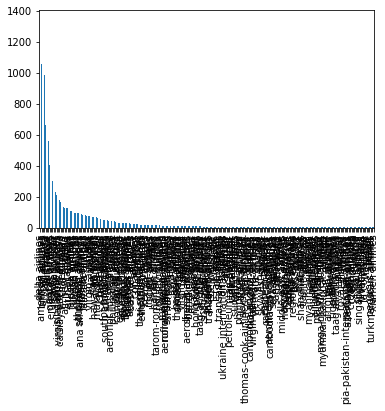

In [97]:
analysis['airline'].value_counts().plot(kind='bar')

In [114]:
# webscrape wiki for list of low-cost airlines 
wikiurl = "https://en.wikipedia.org/wiki/List_of_low-cost_airlines"
import requests # library to handle requests
response = requests.get(wikiurl)
# print(response.status_code) # 200 code means we can legally web scrape it

tables = pd.read_html(wikiurl)

In [387]:
# webscrape wiki for list of low-cost airlines 
wikiurl = "https://www.joaoleitao.com/low-cost-airlines/"
import requests # library to handle requests
# print(response.status_code) # 200 code means we can legally web scrape it

req = requests.get(wikiurl)
soup = BeautifulSoup(req.content, 'html.parser')

In [399]:
text = soup.find_all(text=True)


In [410]:
text

['html',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 ' Search Engine Optimization by Rank Math - https://s.rankmath.com/home ',
 '\n',
 'List Of All The Low-cost Airlines In The World Listed By Continent (2019)',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '{"@context":"https://schema.org","@graph":[{"@type":["Person","Organization"],"@id":"https://www.joaoleitao.com/#person","name":"Jo\\u00e3o Leit\\u00e3o","logo":{"@type":"ImageObject","@id":"https://www.joaoleitao.com/#logo","url":"https://www.joaoleitao.com/wp-content/uploads/2019/05/NOMAD-REVELATIONS-1.png","caption":"Jo\\u00e3o Leit\\u00e3o","inLanguage":"en-US","width":"700","height":"221"},"image":{"@type":"ImageObject","@id":"https://www.joaoleitao.com/#logo","url":"https://www.joaoleitao.com/wp-content/uploads/2019/05/NOMAD-REVELATIONS-1.png","capti

In [401]:
set([t.parent.name for t in text])

{'[document]',
 'a',
 'article',
 'aside',
 'body',
 'button',
 'div',
 'figcaption',
 'footer',
 'form',
 'h1',
 'h2',
 'h3',
 'head',
 'header',
 'html',
 'li',
 'link',
 'main',
 'meta',
 'nav',
 'p',
 'script',
 'section',
 'span',
 'strong',
 'style',
 'svg',
 'title',
 'ul'}

In [417]:

output = ''
blacklist = [
    '[document]',

 'article',
 'aside',
 'body',
 'button',
 'div',
 'figcaption',
 'footer',
 'form',
 'h1',
 'h2',
 'h3',
 'head',
 'header',
 'html',
 'li',
 'link',
 'main',
 'meta',
 'nav',
 'p',
 'script',
 'section',
 'span',
 'strong',
 'style',
 'svg',
 'title',
 'ul'
    # there may be more elements you don't want, such as "style", etc.
]

for t in text:
    if t.parent.name not in blacklist:
        output += '{} '.format(t)

In [418]:
output

'Skip to content \n \n \n About the Author Country guides City guides Adventure Remote Places Motivation Beautiful places Overland Van Life Boat Travel RTW Guides Travel photography Travel Blogs Interviews with Travelers Accommodation Flags Food UNESCO Guides People Resources PT  Africa Americas Antarctica Asia Europe Oceania Resources What is low cost? How to travel with a low cost airline as cheaply as possible 1. Not all low costs are the same 2. Choosing the right time to buy 3. Picking a destination 4. Picking the date 5. Pay attention to offers and deals 6. Being willing to accept the basic services TOP low-cost airlines in Europe Ryanair Easyjet Wizzair Best low-cost airlines in the world  List of Low Cost Airlines in Europe List of Low Cost Airlines in Asia List of Low Cost Airlines in North, Central and South America List of Low Cost Airlines in Australia and the Pacific List of Low Cost Airlines in Africa Europe joining WizzClub Ryanair official website Easyjet official websi

In [122]:
tables[1]

,0,1,2
0,Egypt Air Arabia Egypt Air Cairo FlyEgypt Ken...,NaN,Nigeria Green Africa Airways South Africa Fly...


In [119]:
tables[2][0]

0    Argentina Flybondi[1] JetSmart Argentina[2]  B...
Name: 0, dtype: object

In [121]:
len(tables[2].columns)

3

In [293]:
list_of_lowcost = []
for i in range(1,6):
  l = len(tables[i])
  w = len(tables[i].columns)
  for j in range(w):
    list_of_lowcost.append(str(tables[i][j]))
list_of_lowcost = ' '.join(list_of_lowcost)
list_of_lowcost = list_of_lowcost.replace("\xa0","").replace("\nName: 0, dtype: object","") \
    .replace("NaN","").replace("0   \nName: 1, dtype: float64 0","") \
    .replace("0    ","").replace("\nName: 2, dtype: object","") \
    .replace("[","").replace("]","").replace("1","").replace("2","").replace("3","") \
    .replace("4","").replace("5","").replace("6","").replace("7","").replace("8","").replace("9","") \
    .replace("0","")
list_of_lowcost = list_of_lowcost.lower()
list_of_lowcost = list_of_lowcost + ' ryanair ' + ' spirit ' + " spirit airlines " + ' air asia ' + ' lion air ' \
      + ' indigo ' + ' vueling ' + ' pegasus airlines ' + ' westjet ' + ' spicejet ' + ' flydubai ' + ' southwest airlines ' \
      + ' pegasus airlines ' + ' iberia express ' + ' flynas ' + ' flysafair ' + ' air arabia ' + ' volaris ' \
      + ' viva aerobus ' + ' sunwing airlines ' + ' frontier airlines ' + ' jetblue airways ' + ' gol ' \
      + ' norwegian air shuttle ' + ' cebu pacific ' + ' transavia airlines ' + " allegiant air " \
      + ' vietjetair ' + ' spring airlines ' + ' air arabia ' + ' mango '

In [269]:
list_airlines

['adria airways',
 'aegean airlines',
 'aer lingus',
 'aeroflot russian airlines',
 'aerolineas argentinas',
 'aeromexico',
 'afriqiyah airways',
 'air arabia',
 'air asia',
 'air astana',
 'air austral',
 'air bagan',
 'air berlin',
 'air busan',
 'air canada',
 'air canada rouge',
 'air china',
 'air dolomiti',
 'air europa',
 'air france',
 'air india',
 'air india express',
 'air new zealand',
 'air serbia',
 'air tahiti nui',
 'air transat',
 'air vanuatu',
 'airasia x',
 'aircalin',
 'alaska airlines',
 'alitalia airlines',
 'allegiant air',
 'american airlines',
 'ana',
 'ana all nippon airways',
 'asiana',
 'austrian airlines',
 'avianca',
 'azerbaijan airlines',
 'azul airlines',
 'ba cityflyer',
 'bangkok airways',
 'bassaka air',
 'batik air',
 'british airways',
 'brussels airlines',
 'cambodia angkor airlines',
 'cambodia bayon airlines',
 'canaryfly',
 'cape air',
 'caribbean airlines',
 'cathay pacific airways',
 'cebu pacific',
 'china airlines',
 'china eastern',
 'chi

In [304]:
def func(x):
    if str(x) == 'iberia':
        return 0
    elif str(x) in list_of_lowcost:
        return 1
    elif str(x) == 'NaN':
        return 0
    else:
        return 0

analysis['low_cost'] = analysis['airline'].apply(func)

In [425]:
output.lower()
def func(x):
    if str(x) == 'iberia':
        return 0
    elif str(x) in str(output):
        return 1
    elif str(x) == 'NaN':
        return 0
    else:
        return 0

analysis['low_cost1'] = analysis['airline'].apply(func)

In [426]:
analysis['low_cost1'].value_counts()

0    12803
1       75
Name: low_cost1, dtype: int64

In [444]:
len(analysis[analysis['low_cost'] == 1]['airline'].value_counts())

31

In [297]:
df_final_w_tdidf_pred['low_cost'] = analysis['low_cost']

In [299]:
del df_final_w_tdidf_pred['combined']

In [301]:
df_final_w_tdidf_pred_w_low_cost = df_final_w_tdidf_pred

In [302]:
df_final_w_tdidf_pred_w_low_cost.to_csv('df_final_w_tdidf_pred_w_low_cost.csv')

## Aircraft

In [313]:
analysis['aircraft'].value_counts()

british_airways_airbus_a380_new        236
american_airlines_777-300_er           223
qantas_airways_airbus_a380_b           172
british_airways_boeing_747-400_c       148
american_airlines_boeing_737-800_v2    140
                                      ... 
air_dolomiti_en_embraer_e-195_a          1
air_china_boeing_737-800_b               1
air_china_boeing_737-700                 1
air_china_airbus_a321_b                  1
xiamen_airlines_boeing_787-9             1
Name: aircraft, Length: 848, dtype: int64

In [312]:
analysis['aircraft'] = analysis['aircraft'].str.lower()

In [318]:
def func(x):
    if 'airbus' in str(x):
        return 1
    else:
        return 0

analysis['airbus?'] = analysis['aircraft'].apply(func)
analysis['airbus?'].value_counts()

0    8880
1    3998
Name: airbus?, dtype: int64

In [317]:
def func(x):
    if 'boeing' in str(x):
        return 1
    else:
        return 0

analysis['boeing?'] = analysis['aircraft'].apply(func)
analysis['boeing?'].value_counts()

0    6912
1    5966
Name: boeing?, dtype: int64

In [327]:
def func(x):
    if ('boeing'  not in str(x)) & ('airbus'  not in str(x)) :
        return 1
    else:
        return 0

analysis['other_aircraift'] = analysis['aircraft'].apply(func)
analysis['other_aircraift'].value_counts()

0    9963
1    2915
Name: other_aircraift, dtype: int64

In [328]:
df_final_tino_v1 = analysis

In [329]:
df_final_tino_v1.to_csv('df_final_tino_v1.csv')

# Analysis

## Prepare combined final df

In [330]:
abhi = pd.read_csv('/content/drive/MyDrive/Hackathon M2/sentiments_v2.csv')

In [331]:
abhi

,Unnamed: 0,Unnamed: 0.1,score,title,user_country,user_name,review_date,is_verified,review_body,airline,seat,aircraft,layout,Unnamed: 0.1.1,Cabin Staff Service,Food & Beverages,Ground Service,Recommended,Route,Seat Comfort,Seat Type,Type Of Traveller,Value For Money,Inflight Entertainment,Wifi & Connectivity,link,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,sentiment,sentiment score,topic_name
0,0,2,3.0,Air France customer review,United States,Daniel Rabourn,26-01-2022,1.0,"Yesterday Jan 25, we flew Colombo, Sri Lanka t...",Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0.4192,"flight, time, hour, sleep, configuration, atte...",yesterday jan we flew colombo sri lanka to par...,Negative,-0.2551,inflight-services
1,1,14,5.0,"""All in all, a decent experience""",United Kingdom,S Gorsey,12-05-2021,1.0,It was very nice having a wide body with a 1-...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0.3318,"class, business, service, airline, food, seati...",it was very nice having a wide body with a lie...,Positive,0.9846,business class
2,2,23,7.0,"""business class tagged bag was last to arrive""",United States,Peter Pomeranze,10-04-2021,1.0,Short crowded turbulent flight. Excellent att...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0.2773,"class, business, service, airline, food, seati...",short crowded turbulent flight excellent atten...,Positive,0.7506,business class
3,3,31,2.0,"""no longer giving miles with Economy class""",France,Willy Fischer,18-08-2021,1.0,"Paris CDG to Warsaw , August 16th 2021 Econom...",Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,0.4437,"economy, foot, storage, passenger, bulkhead, a...",paris cdg to warsaw august th economy class as...,Negative,-0.2542,economy class
4,4,36,1.0,"""every shop was closed\3",Russian Federation,Anton Koshelev,13-06-2021,1.0,The worst experience I have had during my int...,Air France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,0.3509,"flight, time, hour, sleep, configuration, atte...",the worst experience i have had during my inte...,Positive,0.6263,inflight-services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12871,12873,34381,NaN,NaN,NaN,Cody,20-12-2016,NaN,I spent the money on for the westjet premium s...,Westjet_,3a,Westjet_Bombardier_Q400,NaN,16740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12873,4,0.4052,"row, leg, room, window, plane, space, exit, si...",i spent the money on for the westjet premium s...,Negative,-0.2960,leg-room
12872,12874,34382,NaN,NaN,NaN,SeatGuru,26-09-2016,NaN,Excellent seat. great view. overhead bins are ...,Westjet_,5C,Westjet_Bombardier_Q400,NaN,16741.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12874,4,0.4086,"row, leg, room, window, plane, space, exit, si...",excellent seat great view overhead bins are qu...,Positive,0.8658,leg-room
12873,12875,34383,NaN,NaN,NaN,SeatGuru,08-03-2016,NaN,Booked 4C off previous comments. Plenty of leg...,Westjet_,4C,Westjet_Bombardier_Q400,NaN,16742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12875,4,0.3964,"row, leg, room, window, plane, space, exit, si...",booked c off previous comments plenty of leg r...,Positive,0.3597,leg-room
12874,12876,34386,NaN,NaN,NaN,SeatGuru,14-05-2015,NaN,"Very poor seat design, a shame for a new aircr...",Westjet_,16C,Westjet_Bombardier_Q400,NaN,16745.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.seatguru.com//airlines/Westjet/Wes...,12876,3,0.4437,"economy, foot, storage, passenger, bulkhead, a...",very poor seat design a shame for a new aircra...,Negative,-0.2924,economy class


In [334]:
tino = df_final_tino_v1[['pred_sentiment_svm', 'pred_sentiment_logisticr', 'low_cost', 'airbus?', 'boeing?', 'other_aircraift']]

In [335]:
df_final = pd.concat([abhi, tino], axis=1)

In [338]:
df_final['sentiment'].value_counts()

Positive    6867
Negative    4874
Neutral     1135
Name: sentiment, dtype: int64

In [346]:
def func(x):
    if x == 'Positive' :
        return 1
    else:
        return 0

df_final['pred_sentiment_vader'] = df_final['sentiment'].apply(func)
df_final['pred_sentiment_vader'].value_counts()

1    6867
0    6011
Name: pred_sentiment_vader, dtype: int64

In [347]:
df_final['combined'] = df_final['pred_sentiment_svm'] + df_final['pred_sentiment_logisticr'] + df_final['pred_sentiment_vader']

In [445]:
df_final['user_country'].value_counts().plot()

United States     200
United Kingdom    200
Australia         147
Canada             99
Singapore          55
                 ... 
Armenia             1
Lebanon             1
Jordan              1
Luxembourg          1
Bahrain             1
Name: user_country, Length: 71, dtype: int64

In [349]:
def func(x):
    if x == 0:
        return 0
    elif x == 1:
        return 0
    elif x == 2:
        return 1
    else:
        return 1

df_final['ensemble_pred_sentiment'] = df_final['combined'].apply(func)
df_final['ensemble_pred_sentiment'].value_counts()

0    8497
1    4381
Name: ensemble_pred_sentiment, dtype: int64

In [352]:
len(df_final[df_final['ensemble_pred_sentiment'] != df_final['pred_sentiment_vader']])

5548

In [337]:
df_final.to_csv('df_final.csv')

In [353]:
df_final1 = df_final[df_final['sentiment'] != 'Neutral']

In [354]:
def func(x):
    if x == 'Positive' :
        return 1
    else:
        return 0

df_final1['pred_sentiment_vader'] = df_final1['sentiment'].apply(func)
df_final1['pred_sentiment_vader'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


1    6867
0    4876
Name: pred_sentiment_vader, dtype: int64

In [355]:
df_final1['combined'] = df_final1['pred_sentiment_svm'] + df_final1['pred_sentiment_logisticr'] + 2*df_final1['pred_sentiment_vader']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [356]:
df_final1['combined'].value_counts()

1    4442
0    3215
3    2180
2    1906
Name: combined, dtype: int64

In [357]:
def func(x):
    if x == 0:
        return 0
    elif x == 1:
        return 0
    elif x == 2:
        return 1
    else:
        return 1

df_final1['ensemble_pred_sentiment'] = df_final1['combined'].apply(func)
df_final1['ensemble_pred_sentiment'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0    7657
1    4086
Name: ensemble_pred_sentiment, dtype: int64

In [358]:
len(df_final1[df_final1['ensemble_pred_sentiment'] != df_final1['pred_sentiment_vader']])

5253

## EDA

## Ratings

In [379]:
# average score/rating of low-cost airlines
number_of_low_cost = len(df_final[df_final['low_cost'] == 1]['score'])
lc_avg = df_final[df_final['low_cost'] == 1]['score'].mean()

print(f'The low-cost airlines have an average rating of {lc_avg}')

The low-cost airlines have an average rating of 5.048076923076923


In [380]:
# average score/rating of normal airlines
number_of_nc = len(df_final[df_final['low_cost'] == 0]['score'])
nc_avg = df_final[df_final['low_cost'] == 0]['score'].mean()

print(f'The normal-cost airlines have an average rating of {nc_avg}')

The normal-cost airlines have an average rating of 5.532803180914513


In [431]:
all_data = pd.read_csv('/content/drive/MyDrive/Hackathon M2/Our Data/Merged_data_with_date.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3,6,11,13,14,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [434]:
all_data['year'] = pd.DatetimeIndex(all_data['review_date']).year

In [437]:
all_data['year'].value_counts()

2017.0    5662
2019.0    5142
2018.0    4999
2016.0    4996
2015.0    3540
2021.0    3232
2020.0    2405
2014.0    1836
2022.0    1203
2013.0     532
2012.0     111
2011.0      76
2010.0      60
2009.0      50
2008.0       8
Name: year, dtype: int64

In [ ]:
nc_avg = all_data[all_data['year'] == 0]['score'].mean()

print(f'The normal-cost airlines have an average rating of {nc_avg}')

In [4]:
df_final = pd.read_csv('/content/drive/MyDrive/Hackathon M2/Our Data/df_final.csv')

In [5]:
df_final['aircraft'].value_counts()

British_Airways_Airbus_A380_new        236
American_Airlines_777-300_ER           223
Qantas_Airways_Airbus_A380_B           172
British_Airways_Boeing_747-400_C       148
American_Airlines_Boeing_737-800_V2    140
                                      ... 
Saudia_Airbus_A321                       1
Scoot_Airlines_Boeing_787-8_V2           1
BOEING 777-300ER/bÃ£â‚¬â€°               1
Shanghai_Airlines_Boeing_737-700         1
Xiamen_Airlines_Boeing_787-9             1
Name: aircraft, Length: 862, dtype: int64

In [10]:
len(df_final[df_final['airbus?'] == 1]['aircraft'].unique())



387

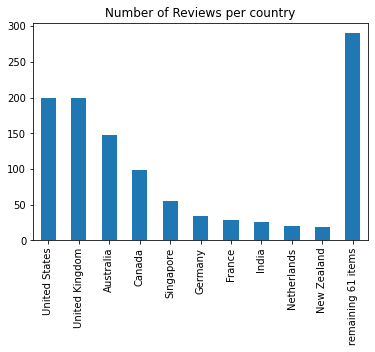

In [449]:
temp = df_final['user_country'].value_counts()

temp2 = temp.head(10)
if len(temp) > 10:
    temp2['remaining {0} items'.format(len(temp) - 10)] = sum(temp[10:])
temp2.plot(kind='bar', title='Number of Reviews per country')